In [1]:
import os
from pathlib import Path

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline
# Any results you write to the current directory are saved as output.

In [2]:
INPUT_PATH = Path('..','input')
TRAIN_PATH = Path(INPUT_PATH, 'train.csv')
TEST_PATH = Path(INPUT_PATH, 'test.csv')

train = pd.read_csv(TRAIN_PATH, index_col='id', parse_dates=['pickup_datetime', 'dropoff_datetime'])
train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
test = pd.read_csv(TEST_PATH, index_col='id', parse_dates=['pickup_datetime'])
test.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
id,,,,,,,,
id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


# EDA

Date extraction

In [4]:
def extract_date_info(df, cols):
    for col in cols:
        df[col + '_month'] = df[col].dt.month
        df[col + '_week'] = df[col].dt.week
        df[col + '_dow'] = df[col].dt.dayofweek
        df[col + '_hour'] = df[col].dt.hour
        df[col + '_date'] = df[col].dt.date
    return df

In [5]:
train = extract_date_info(train, ['pickup_datetime', 'dropoff_datetime'])
test = extract_date_info(test, ['pickup_datetime'])
train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_month,pickup_datetime_week,pickup_datetime_dow,pickup_datetime_hour,pickup_datetime_date,dropoff_datetime_month,dropoff_datetime_week,dropoff_datetime_dow,dropoff_datetime_hour,dropoff_datetime_date
id,,,,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,11,0,17,2016-03-14,3,11,0,17,2016-03-14
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,23,6,0,2016-06-12,6,23,6,0,2016-06-12
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,3,1,11,2016-01-19,1,3,1,12,2016-01-19
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,14,2,19,2016-04-06,4,14,2,19,2016-04-06
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,12,5,13,2016-03-26,3,12,5,13,2016-03-26


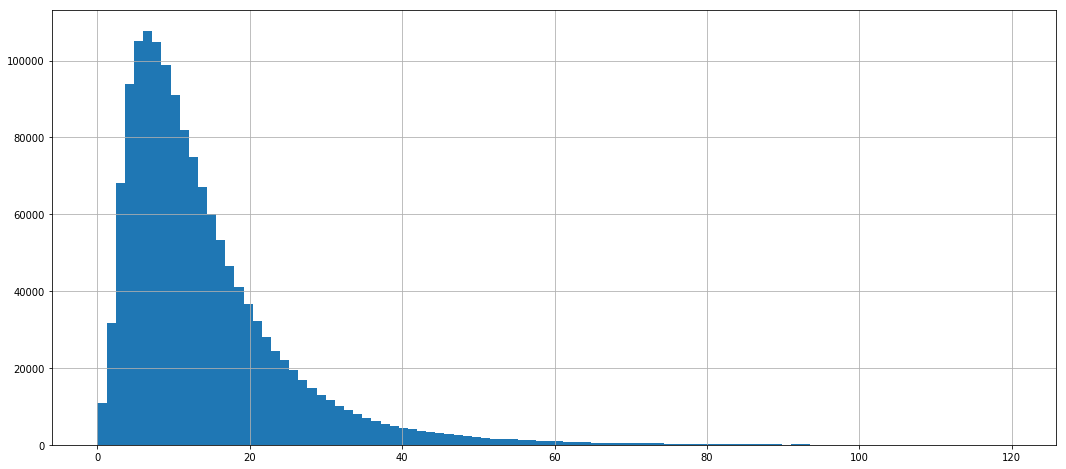

In [6]:
#it seems that we have some very long trips that prevent us from looking at the ditribution let's plot all trip < 2h
fig, ax = plt.subplots(figsize=(18,8))
(train.loc[train['trip_duration'] < 2*3600, 'trip_duration'] /60).hist(bins= 100, ax=ax);
#seems like most of the traject are below 40 mins

In [7]:
#I'm now going to add the distance in my dataframe using the flight distance as the crow flies
#got the distance function from: https://janakiev.com/blog/gps-points-distance-python/

def haversine(lat1, lon1, lat2, lon2):
    R = 6372800  # Earth radius in meters  
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [8]:
train['distance'] = train.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

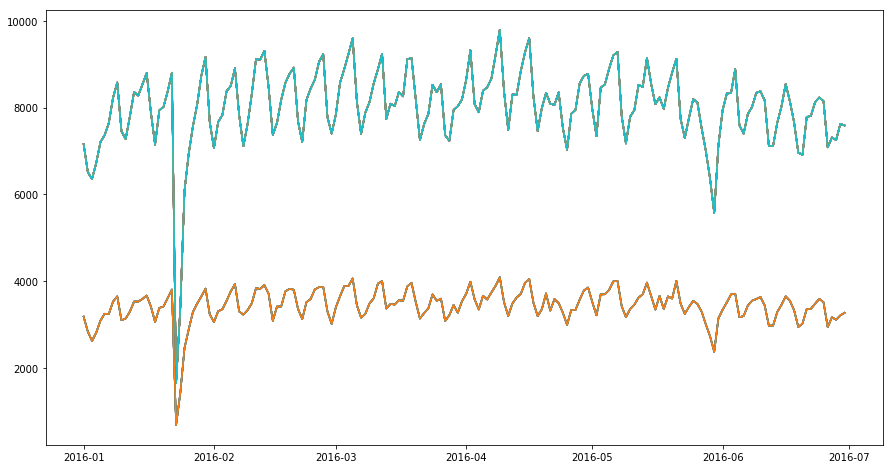

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.groupby('pickup_datetime_date').count())
ax.plot(test.groupby('pickup_datetime_date').count());

The 2 dataframes exactly overlaps on time so I will use this in my feature engineering and calulate a average speed per day

In [17]:
#next step : Speed

#train['speed'] = (train['distance'] / train['trip_duration'])*3,6 

In [18]:
train.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_datetime_month,pickup_datetime_week,pickup_datetime_dow,pickup_datetime_hour,pickup_datetime_date,dropoff_datetime_month,dropoff_datetime_week,dropoff_datetime_dow,dropoff_datetime_hour,dropoff_datetime_date,distance,speed
id,,,,,,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,11,0,17,2016-03-14,3,11,0,17,2016-03-14,1498.944157,9.151063e-07
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,23,6,0,2016-06-12,6,23,6,0,2016-06-12,1806.017279,7.566689e-07
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,3,1,11,2016-01-19,1,3,1,12,2016-01-19,6386.902479,8.352823e-07
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,14,2,19,2016-04-06,4,14,2,19,2016-04-06,1485.918121,9.621329e-07
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,12,5,13,2016-03-26,3,12,5,13,2016-03-26,1188.924271,7.592109e-07


# Feature selection + preprocess

In [11]:
#loss =  - (cross_val_score(rf, X_baseline, y_baseline, cv=5, scoring='neg_mean_squared_error'))

In [ ]:
X = train.drop(columns=['pickup_datetime', 'dropoff_datetime', 'trip_duration', 
                                 'pickup_datetime_date', 'dropoff_datetime_month',
                                 'dropoff_datetime_week','dropoff_datetime_dow',
                                 'dropoff_datetime_hour', 'dropoff_datetime_date'])
for c in X.select_dtypes('object').columns:
    X[c] = X[c].astype('category').cat.codes
y = np.log1p(train['trip_duration'])

In [ ]:
X.info()

# Processing test.set

In [ ]:
X_test = test.drop(columns=['pickup_datetime', 'pickup_datetime_date'])

for c in X_test.select_dtypes('object').columns:
    X_test[c] = X_test[c].astype('category').cat.codes
    
X_test['distance'] = test.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
X_test.info()

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)
Loss =  cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
np.mean(np.sqrt(-Loss))

In [ ]:
rf.fit(X, y)
log_pred = rf.predict(X_test)
pred = np.exp(log_pred) - 1

In [ ]:
SUBMIT_PATH = Path(INPUT_PATH, 'sample_submission.csv')
submit = pd.read_csv(SUBMIT_PATH)

arr_id = submit['id']
submission = pd.DataFrame({'id': arr_id, 'trip_duration': pred})
submission.head()

In [ ]:
fi_dict = {
    'feats': X.columns,
    'feature_importance': rf.feature_importances_
}
fi = pd.DataFrame(fi_dict).set_index('feats').sort_values(
    'feature_importance', ascending=False)
fi.sort_values(
    'feature_importance', ascending=True).tail(10).plot.barh();

In [ ]:
submission.to_csv("submission.csv", index=False)